## Google Drive

In [2]:
DRIVE_MOUNT_PATH = '/content/drive'
BASE_DIR = DRIVE_MOUNT_PATH + "/MyDrive/digitalent/dsc2024"
DATASET_PATH = BASE_DIR + "/data/elongated_word_10k.csv"
MODELS_DIR = BASE_DIR + "/indobert/models"

In [3]:
from google.colab import drive
drive.mount(DRIVE_MOUNT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [4]:
!pip install git+https://github.com/huggingface/transformers datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-so624d3m
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-so624d3m
  Resolved https://github.com/huggingface/transformers to commit b54109c7466f6e680156fbd30fa929e2e222d730
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:

In [5]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import datasets
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

## Settings

In [6]:
BATCH_SIZE = 16
MODEL_ID = "indolem/indobert-base-uncased"
TOKEN_MAX_LENGTH = 512
NUM_EPOCHS = 5

## Dataset preparation

### Load

In [7]:
df = pd.read_csv(DATASET_PATH)
df = df[:10000]
df.drop(columns=["tokens"], inplace=True)
df.rename(columns={"news": "text", "is_fake": "label"}, inplace=True)
print(df)

# Train-test split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Convert to Hugging Face Dataset
train_dataset = datasets.Dataset.from_dict(train_df)
test_dataset = datasets.Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

                                                   text  label
0     covid <NUMBER> subvarian xb berbeda  mematikan...      1
1     video salat berbahasa indonesia kursus salat d...      1
2     warga bogor meninggal hidup kembali    ajaib  ...      1
3     ikan alien aneh dijumpai di sungai madeira  br...      1
4     foto foto pemberontakan ulama dan santri di ma...      1
...                                                 ...    ...
9995  dicari  partai partai  pemersatu  bangsa endor...      0
9996  ksal yudo akui siap jalani fit and proper test...      0
9997  veronica koman dan data tahanan politik papua ...      0
9998  p ungkap kader ingin usung anies di pilpres <N...      0
9999  ngabalin sentil komitmen kepala daerah terkait...      0

[10000 rows x 2 columns]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Tokenize

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=TOKEN_MAX_LENGTH)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

### Convert to Tensorflow format

In [9]:
# Train Dataset
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    label_cols='label'
)

# Test Dataset
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    label_cols='label'
)

## Model

### Setup

In [10]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=1,
    from_pt=True
)

# Make BERT layer untrainable
model.layers[0].trainable = False

# Change classifier layer activation to sigmoid
model.layers[-1].activation = keras.activations.sigmoid

model.summary()

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 110558977 (421.75 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 110558208 (421.75 MB)
_________________________________________________________________


In [13]:
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

# Optimizer
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
  )

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy', keras.metrics.Recall(), keras.metrics.AUC()])

### Train

In [14]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=NUM_EPOCHS
)

Epoch 1/5
500/500 [==============================] - 459s 884ms/step - loss: 0.6074 - accuracy: 0.7544 - recall: 0.6072 - auc: 0.8864 - val_loss: 0.5619 - val_accuracy: 0.8055 - val_recall: 0.7061 - val_auc: 0.9232
Epoch 2/5
500/500 [==============================] - 439s 878ms/step - loss: 0.5614 - accuracy: 0.8039 - recall: 0.7139 - auc: 0.9108 - val_loss: 0.5239 - val_accuracy: 0.8350 - val_recall: 0.7959 - val_auc: 0.9282
Epoch 3/5
500/500 [==============================] - 440s 881ms/step - loss: 0.5343 - accuracy: 0.8285 - recall: 0.7791 - auc: 0.9156 - val_loss: 0.5008 - val_accuracy: 0.8500 - val_recall: 0.8306 - val_auc: 0.9301
Epoch 4/5
500/500 [==============================] - 438s 877ms/step - loss: 0.5198 - accuracy: 0.8307 - recall: 0.7918 - auc: 0.9148 - val_loss: 0.4881 - val_accuracy: 0.8575 - val_recall: 0.8490 - val_auc: 0.9311
Epoch 5/5
500/500 [==============================] - 440s 881ms/step - loss: 0.5100 - accuracy: 0.8360 - recall: 0.8010 - auc: 0.9178 - val_

### Save

In [15]:
prefix = "indobert_"
timestr = time.strftime("%Y%m%d-%H%M%S")
ext = ".keras"

filename = prefix + timestr + ext
model.save(MODELS_DIR + "/" + filename)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


### Plot

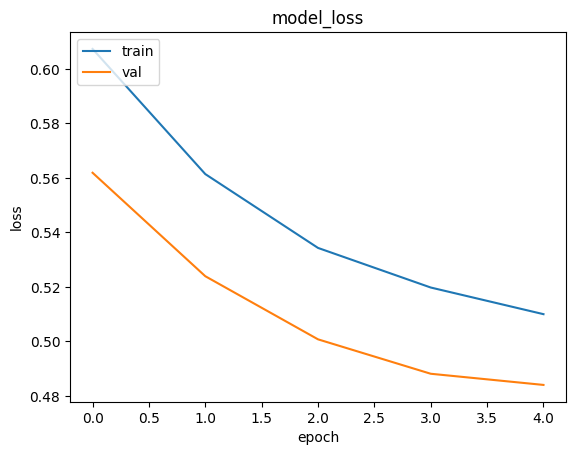

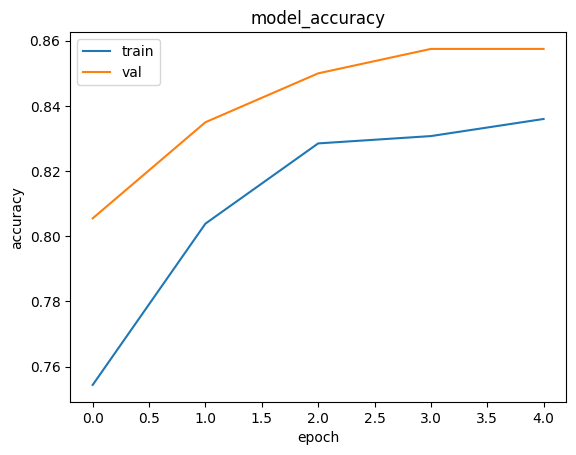

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Load model

In [ ]:
MODEL_PATH = MODELS_DIR + "/indobert_20241014-033003.keras"
model = keras.models.load_model(MODEL_PATH)

# Make BERT layer untrainable
model.layers[0].trainable = False

# Change classifier layer activation to sigmoid
model.layers[-1].activation = keras.activations.sigmoid

model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
 dropout_151 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 110558977 (421.75 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 110558208 (421.75 MB)
_________________________________________________________________


## Setup

In [ ]:
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

# Optimizer
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
  )
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy', keras.metrics.Recall(), keras.metrics.AUC()])

## Retrain

In [ ]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=NUM_EPOCHS
)

Epoch 1/3
1000/1000 [==============================] - 464s 451ms/step - loss: 0.5218 - accuracy: 0.8281 - recall_4: 0.7908 - auc_5: 0.9150 - val_loss: 0.4736 - val_accuracy: 0.8520 - val_recall_4: 0.8469 - val_auc_5: 0.9344
Epoch 2/3
1000/1000 [==============================] - 447s 447ms/step - loss: 0.4828 - accuracy: 0.8481 - recall_4: 0.8313 - auc_5: 0.9215 - val_loss: 0.4467 - val_accuracy: 0.8625 - val_recall_4: 0.8724 - val_auc_5: 0.9365
Epoch 3/3
1000/1000 [==============================] - 448s 448ms/step - loss: 0.4695 - accuracy: 0.8508 - recall_4: 0.8413 - auc_5: 0.9208 - val_loss: 0.4388 - val_accuracy: 0.8645 - val_recall_4: 0.8765 - val_auc_5: 0.9371


## Resave

In [ ]:
prefix = "indobert_"
timestr = time.strftime("%Y%m%d-%H%M%S")
ext = ".keras"

filename = prefix + timestr + ext
model.save(MODELS_DIR + "/" + filename)

## Replot

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Demo

In [17]:
input_texts = [
    "Jokowi maju jadi presiden ketiga kali",
    "Makan nasi bisa tambah gemuk?"
]
inputs = tokenizer(input_texts, padding=True,return_tensors="tf")
logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[0.5742738]
 [0.7102372]], shape=(2, 1), dtype=float32)
